In [340]:
import os
import pandas as pd
import numpy as np
import bioframe
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import fisher_exact
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

In [2]:
def read_variants(sample):
    variants = pd.read_csv(f'/DATA/users/m.magnitov/hap_phen/personal_genomes/{sample}/{sample}.phased.het.bed', 
                           sep = '\t', header = None)
    variants[11] = [int(x.split('|')[0]) for x in variants[10].values]
    variants[12] = [int(x.split('|')[1].split(':')[0]) for x in variants[10].values]
    variants = variants[[0, 2, 2, 3, 5, 6, 11, 12]]
    variants.columns = ['chrom', 'start', 'end', 'variant_id', 'ref', 'alt', 'allele_ref', 'allele_alt']
    return(variants)

def get_variants_for_links(phased_variants, links):
    phased_variants_overlap_links = bioframe.overlap(phased_variants, links,  
                                                     cols2 = ('chrom_peak', 'start_peak', 'end_peak'),
                                                     suffixes = ('_variant', ''))
    phased_variants_overlap_links = phased_variants_overlap_links.dropna()
    phased_variants_overlap_links = phased_variants_overlap_links.drop('distance', axis = 1)

    putative_non_overlaps = links[~links['peak_id'].isin(phased_variants_overlap_links['peak_id'])]['peak_id'].values
    if len(putative_non_overlaps) != 0:
        links_non_overlaps = links[links['peak_id'].isin(putative_non_overlaps)]

        phased_variants_overlap_non_overlaps = bioframe.closest(links_non_overlaps, phased_variants, 
                     cols1 = ('chrom_peak', 'start_peak', 'end_peak'),
                     suffixes = ('', '_variant'))
        sort_order = list(phased_variants_overlap_non_overlaps.columns[-9:]) + list(phased_variants_overlap_non_overlaps.columns[:-9])
        phased_variants_overlap_non_overlaps = phased_variants_overlap_non_overlaps[sort_order]
        phased_variants_overlap_non_overlaps = phased_variants_overlap_non_overlaps.drop('distance', axis = 1)

    phased_variants_overlap_links = pd.concat([phased_variants_overlap_links, phased_variants_overlap_non_overlaps], ignore_index = True)
    phased_variants_overlap_links = phased_variants_overlap_links.sort_values(['chrom_variant', 'start_variant'])
    phased_variants_overlap_links.index = np.arange(len(phased_variants_overlap_links))
    phased_variants_overlap_links['gene_id'] = [x.split('.')[0] for x in phased_variants_overlap_links['gene_id']]
    phased_variants_overlap_links['variant_link_id'] = ['variant_link_' + str(x) for x in np.arange(len(phased_variants_overlap_links))+1]
    return(phased_variants_overlap_links)

def read_significant_gtex_data(tissue_name):
    gtex_data = pd.read_csv(f'/DATA/users/m.magnitov/hap_phen/links/gtex_data/{tissue_name}.v8.signif_variant_gene_pairs.txt.gz', sep = '\t')
    gtex_data['chrom'] = [x.split('_')[0] for x in gtex_data['variant_id']]
    gtex_data['start'] = [int(x.split('_')[1]) for x in gtex_data['variant_id']]
    gtex_data['end'] = [int(x.split('_')[1]) for x in gtex_data['variant_id']]
    gtex_data['ref'] = [x.split('_')[2] for x in gtex_data['variant_id']]
    gtex_data['alt'] = [x.split('_')[3] for x in gtex_data['variant_id']]
    gtex_data['gene_id'] = [x.split('.')[0] for x in gtex_data['gene_id']]
    gtex_data = gtex_data[['chrom', 'start', 'end', 'ref', 'alt', 'gene_id', 'maf', 'slope']]
    return(gtex_data)

## Links in GTEx LCLs eQTL

In [3]:
gtex_data_all = pd.read_csv(f'/DATA/users/m.magnitov/hap_phen/links/gtex_data/GTEx_Analysis_v8_QTLs_GTEx_Analysis_v8_eQTL_all_associations_Cells_EBV-transformed_lymphocytes.allpairs.txt.gz', sep = '\t')
gtex_data_all['chrom'] = [x.split('_')[0] for x in gtex_data_all['variant_id']]
gtex_data_all['start'] = [int(x.split('_')[1]) for x in gtex_data_all['variant_id']]
gtex_data_all['end'] = [int(x.split('_')[1]) for x in gtex_data_all['variant_id']]
gtex_data_all['ref'] = [x.split('_')[2] for x in gtex_data_all['variant_id']]
gtex_data_all['alt'] = [x.split('_')[3] for x in gtex_data_all['variant_id']]
gtex_data_all['gene_id'] = [x.split('.')[0] for x in gtex_data_all['gene_id']]
gtex_data_all = gtex_data_all[['chrom', 'start', 'end', 'ref', 'alt', 'gene_id', 'maf', 'slope']]
gtex_all_genes = np.unique(gtex_data_all['gene_id'].values)

In [4]:
gtex_data_all.head()

,chrom,start,end,ref,alt,gene_id,maf,slope
0,chr1,13550,13550,G,A,ENSG00000227232,0.017007,0.325300
1,chr1,14671,14671,G,C,ENSG00000227232,0.017007,-0.331665
2,chr1,14677,14677,G,A,ENSG00000227232,0.044218,0.091770
3,chr1,16841,16841,G,T,ENSG00000227232,0.023810,-0.482607
4,chr1,16856,16856,A,G,ENSG00000227232,0.003401,-0.387836


In [5]:
gtex_data_sign = pd.read_csv(f'/DATA/users/m.magnitov/hap_phen/links/gtex_data/Cells_EBV-transformed_lymphocytes.v8.signif_variant_gene_pairs.txt.gz', sep = '\t')
gtex_data_sign['chrom'] = [x.split('_')[0] for x in gtex_data_sign['variant_id']]
gtex_data_sign['start'] = [int(x.split('_')[1]) for x in gtex_data_sign['variant_id']]
gtex_data_sign['end'] = [int(x.split('_')[1]) for x in gtex_data_sign['variant_id']]
gtex_data_sign['ref'] = [x.split('_')[2] for x in gtex_data_sign['variant_id']]
gtex_data_sign['alt'] = [x.split('_')[3] for x in gtex_data_sign['variant_id']]
gtex_data_sign['gene_id'] = [x.split('.')[0] for x in gtex_data_sign['gene_id']]
gtex_data_sign = gtex_data_sign[['chrom', 'start', 'end', 'ref', 'alt', 'gene_id', 'maf', 'slope']]

In [6]:
gtex_data_variants = pd.read_csv('/DATA/users/m.magnitov/hap_phen/links/gtex_data/GTEx_Analysis_2017-06-05_v8_WholeGenomeSeq_838Indiv_Analysis_Freeze.lookup_table.txt.gz', sep = '\t')
gtex_data_variants['start'] = gtex_data_variants['variant_pos']
gtex_data_variants['end'] = gtex_data_variants['variant_pos']
gtex_data_variants = gtex_data_variants[['chr', 'start', 'end', 'ref', 'alt']]

In [ ]:
for sample in ['HG01241', 'HG02601', 'HG03464']:
    print(sample)

    phased_variants = read_variants(sample)

    links_allele_specific = pd.read_csv(f'links_{sample}_allele_specific.txt', sep = '\t', header = 0)
    links_balanced = pd.read_csv(f'links_{sample}_balanced.txt', sep = '\t', header = 0)

    variants_links_allele_specific = get_variants_for_links(phased_variants, links_allele_specific)
    variants_links_balanced = get_variants_for_links(phased_variants, links_balanced)

    variants_links_allele_specific_in_gtex_sign = variants_links_allele_specific.merge(gtex_data_sign, 
                                                                                       left_on = ['chrom_variant', 'start_variant', 'ref_variant', 'alt_variant', 'gene_id'], 
                                                                                       right_on = ['chrom', 'start', 'ref', 'alt', 'gene_id'])

    variants_links_allele_specific_in_gtex_all = variants_links_allele_specific.merge(gtex_data_all, 
                                                                                      left_on = ['chrom_variant', 'start_variant', 'ref_variant', 'alt_variant', 'gene_id'], 
                                                                                      right_on = ['chrom', 'start', 'ref', 'alt', 'gene_id'])

    variants_links_allele_specific_in_gtex_variants = variants_links_allele_specific.merge(gtex_data_variants, 
                                                                                           left_on = ['chrom_variant', 'start_variant', 'ref_variant', 'alt_variant'], 
                                                                                           right_on = ['chr', 'start', 'ref', 'alt'])

    variants_links_balanced_in_gtex_sign = variants_links_balanced.merge(gtex_data_sign, 
                                                                         left_on = ['chrom_variant', 'start_variant', 'ref_variant', 'alt_variant', 'gene_id'], 
                                                                         right_on = ['chrom', 'start', 'ref', 'alt', 'gene_id'])

    variants_links_balanced_in_gtex_all = variants_links_balanced.merge(gtex_data_all, 
                                                                        left_on = ['chrom_variant', 'start_variant', 'ref_variant', 'alt_variant', 'gene_id'], 
                                                                        right_on = ['chrom', 'start', 'ref', 'alt', 'gene_id'])

    variants_links_balanced_in_gtex_variants = variants_links_balanced.merge(gtex_data_variants, 
                                                                             left_on = ['chrom_variant', 'start_variant', 'ref_variant', 'alt_variant'], 
                                                                             right_on = ['chr', 'start', 'ref', 'alt'])

    
    links_allele_specific['gene_id'] = [x.split('.')[0] for x in links_allele_specific['gene_id'].values]
    no_gene_as = len(links_allele_specific)-len(links_allele_specific[links_allele_specific['gene_id'].isin(gtex_all_genes)])
    
    gtex_sign_count, gtex_all_count, gtex_variants_count, other_count = 0, 0, 0, 0
    for variant_link_id in variants_links_allele_specific['variant_link_id'].values:
        if variant_link_id in variants_links_allele_specific_in_gtex_sign['variant_link_id'].values:
            gtex_sign_count += 1
        elif variant_link_id in variants_links_allele_specific_in_gtex_all['variant_link_id'].values:
            gtex_all_count += 1
        elif variant_link_id in variants_links_allele_specific_in_gtex_variants['variant_link_id'].values:
            gtex_variants_count += 1
        else:
            other_count += 1
    counts_total_as = np.array([gtex_sign_count, gtex_all_count, gtex_variants_count, other_count-no_gene_as, no_gene_as])

    
    links_balanced['gene_id'] = [x.split('.')[0] for x in links_balanced['gene_id'].values]
    no_gene_balanced = len(links_balanced)-len(links_balanced[links_balanced['gene_id'].isin(gtex_all_genes)])
    
    gtex_sign_count, gtex_all_count, gtex_variants_count, other_count = 0, 0, 0, 0
    for variant_link_id in variants_links_balanced['variant_link_id'].values:
        if variant_link_id in variants_links_balanced_in_gtex_sign['variant_link_id'].values:
            gtex_sign_count += 1
        elif variant_link_id in variants_links_balanced_in_gtex_all['variant_link_id'].values:
            gtex_all_count += 1
        elif variant_link_id in variants_links_balanced_in_gtex_variants['variant_link_id'].values:
            gtex_variants_count += 1
        else:
            other_count += 1
    counts_total_balanced = np.array([gtex_sign_count, gtex_all_count, gtex_variants_count, other_count-no_gene_balanced, no_gene_balanced])
    
    print(counts_total_as)
    print(counts_total_balanced)

In [4]:
gtex_abundance = [[134, 917, 406, 145, 112], [3836, 386312, 76172, 43364, 29216],
                  [69, 1120, 443, 382, 130], [3437, 369255, 71409, 57229, 24124],
                  [73, 700, 344, 459, 95], [3479, 468210, 151695, 70183, 34020],
                  [60, 774, 230, 429, 94], [3391, 361945, 69819, 55946, 24810],
                  [186, 2683, 1679, 1071, 306], [3958, 624549, 251341, 109844, 46211]]

gtex_abundance = pd.DataFrame(gtex_abundance).transpose()
gtex_abundance.columns = ['NA12878_as', 'NA12878_balanced', 'NA18983_as', 'NA18983_balanced', 'HG01241_as', 'HG01241_balanced', 'HG02601_as', 'HG02601_balanced', 'HG03464_as', 'HG03464_balanced']
gtex_abundance.index = ['eqtl', 'tested_not_significant', 'not_tested_low_maf', 'not_genotyped_variant', 'no_gene_in_annotation']
gtex_abundance.to_csv('overlap_links_with_gtex_all_categories.tsv', sep = '\t', header = 1, index = 1)
gtex_abundance

,NA12878_as,NA12878_balanced,NA18983_as,NA18983_balanced,HG01241_as,HG01241_balanced,HG02601_as,HG02601_balanced,HG03464_as,HG03464_balanced
eqtl,134,3836,69,3437,73,3479,60,3391,186,3958
tested_not_significant,917,386312,1120,369255,700,468210,774,361945,2683,624549
not_tested_low_maf,406,76172,443,71409,344,151695,230,69819,1679,251341
not_genotyped_variant,145,43364,382,57229,459,70183,429,55946,1071,109844
no_gene_in_annotation,112,29216,130,24124,95,34020,94,24810,306,46211


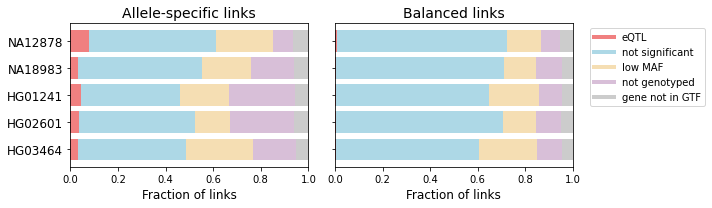

In [5]:
plt.figure(figsize = (10, 3))

plt.subplot(121)
plt.title('Allele-specific links', fontsize = 14)
for (i, sample) in enumerate(['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464']):
    fractions_to_plot = gtex_abundance[f'{sample}_as'].values/np.sum(gtex_abundance[f'{sample}_as'])
    fractions_to_plot = [np.sum(fractions_to_plot[:x+1]) for x in range(5)][::-1]
    plt.barh([5-i]*len(fractions_to_plot), fractions_to_plot, color = ['#CCCCCC', 'thistle', 'wheat', 'lightblue', 'lightcoral'])

plt.xlabel('Fraction of links', fontsize = 12)    
plt.yticks(np.arange(5)+1, ['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464'][::-1], fontsize = 12)
plt.xlim((0, 1))

plt.subplot(122)
plt.title('Balanced links', fontsize = 14)
for (i, sample) in enumerate(['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464']):
    fractions_to_plot = gtex_abundance[f'{sample}_balanced'].values/np.sum(gtex_abundance[f'{sample}_balanced'])
    fractions_to_plot = [np.sum(fractions_to_plot[:x+1]) for x in range(5)][::-1]
    plt.barh([5-i]*len(fractions_to_plot), fractions_to_plot, color = ['#CCCCCC', 'thistle', 'wheat', 'lightblue', 'lightcoral'])

plt.xlabel('Fraction of links', fontsize = 12)
plt.yticks(np.arange(5)+1, [], fontsize = 12)
plt.xlim((0, 1))

custom_lines = [Line2D([0], [0], color='lightcoral', lw=4),
                Line2D([0], [0], color='lightblue', lw=4),
                Line2D([0], [0], color='wheat', lw=4),
                Line2D([0], [0], color='thistle', lw=4),
                Line2D([0], [0], color='#CCCCCC', lw=4)]
plt.legend(custom_lines, ['eQTL', 'not significant', 'low MAF', 'not genotyped', 'gene not in GTF'], bbox_to_anchor = (1.05, 1))

plt.tight_layout()
plt.show()

NA12878 [0.9999999999999999, 0.9094881398252184, 0.6560549313358301, 0.08364544319600499]
NA18983 [0.9999999999999999, 0.8103277060575967, 0.5903674280039721, 0.03426017874875869]
HG01241 [1.0, 0.708756345177665, 0.49048223350253806, 0.04631979695431472]
HG02601 [1.0, 0.7126590756865372, 0.5586068318821166, 0.04018754186202277]
HG03464 [1.0, 0.8093966898024559, 0.5105890727887524, 0.03310197544046983]
NA12878 [1.0, 0.9149198326806414, 0.7654703698762371, 0.0075262319397901446]
NA18983 [1.0, 0.8858456505694852, 0.7434065386073045, 0.006855763668641414]
HG01241 [1.0, 0.8988086226709171, 0.6800914691731296, 0.005016097940069237]
HG02601 [1.0, 0.8860804600275707, 0.7439121484175353, 0.006904893290789471]
HG03464 [1.0, 0.8890119350262506, 0.6350531276397101, 0.003999224001002332]


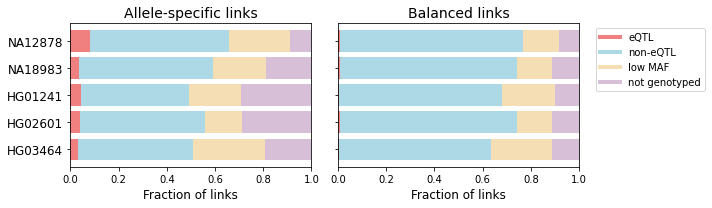

In [8]:
plt.figure(figsize = (10, 3))

plt.subplot(121)
plt.title('Allele-specific links', fontsize = 14)
for (i, sample) in enumerate(['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464']):
    fractions_to_plot = gtex_abundance.drop(['no_gene_in_annotation'])[f'{sample}_as'].values/np.sum(gtex_abundance.drop(['no_gene_in_annotation'])[f'{sample}_as'])
    fractions_to_plot = [np.sum(fractions_to_plot[:x+1]) for x in range(4)][::-1]
    plt.barh([5-i]*len(fractions_to_plot), fractions_to_plot, color = ['thistle', 'wheat', 'lightblue', 'lightcoral'])
    print(sample, fractions_to_plot)

plt.xlabel('Fraction of links', fontsize = 12)    
plt.yticks(np.arange(5)+1, ['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464'][::-1], fontsize = 12)
plt.xlim((0, 1))

plt.subplot(122)
plt.title('Balanced links', fontsize = 14)
for (i, sample) in enumerate(['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464']):
    fractions_to_plot = gtex_abundance.drop(['no_gene_in_annotation'])[f'{sample}_balanced'].values/np.sum(gtex_abundance.drop(['no_gene_in_annotation'])[f'{sample}_balanced'])
    fractions_to_plot = [np.sum(fractions_to_plot[:x+1]) for x in range(4)][::-1]
    plt.barh([5-i]*len(fractions_to_plot), fractions_to_plot, color = ['thistle', 'wheat', 'lightblue', 'lightcoral'])
    print(sample, fractions_to_plot)

plt.xlabel('Fraction of links', fontsize = 12)
plt.yticks(np.arange(5)+1, [], fontsize = 12)
plt.xlim((0, 1))

custom_lines = [Line2D([0], [0], color = 'lightcoral', lw=4),
                Line2D([0], [0], color = 'lightblue', lw = 4),
                Line2D([0], [0], color = 'wheat', lw=4),
                Line2D([0], [0], color = 'thistle', lw=4)]
plt.legend(custom_lines, ['eQTL', 'non-eQTL', 'low MAF', 'not genotyped'], bbox_to_anchor = (1.05, 1))

plt.tight_layout()
plt.savefig('/DATA/users/m.magnitov/hap_phen/figures/links_gtex_counts_by_category.pdf', bbox_inches = 'tight')
plt.show()

## Concordance of links with GTEx slopes

In [399]:
def gtex_slope_odds_ratio(variants_gtex):
    pp = len(variants_gtex[(variants_gtex['log2FoldChange_peak'] > 0) & \
                           (variants_gtex['slope']*(variants_gtex['allele_alt_variant']-variants_gtex['allele_ref_variant']) > 0)])
    pn = len(variants_gtex[(variants_gtex['log2FoldChange_peak'] > 0) & \
                           (variants_gtex['slope']*(variants_gtex['allele_alt_variant']-variants_gtex['allele_ref_variant']) < 0)])
    np = len(variants_gtex[(variants_gtex['log2FoldChange_peak'] < 0) & \
                           (variants_gtex['slope']*(variants_gtex['allele_alt_variant']-variants_gtex['allele_ref_variant']) > 0)])
    nn = len(variants_gtex[(variants_gtex['log2FoldChange_peak'] < 0) & \
                           (variants_gtex['slope']*(variants_gtex['allele_alt_variant']-variants_gtex['allele_ref_variant']) < 0)])
    print('Total:', [[pp, pn], [np, nn]])

    if 'concordant' in variants_gtex.columns:
        pp_conc = len(variants_gtex[(variants_gtex['concordant'] > 0) &\
                                    (variants_gtex['log2FoldChange_peak'] > 0) & \
                                    (variants_gtex['slope']*(variants_gtex['allele_alt_variant']-variants_gtex['allele_ref_variant']) > 0)])
        pn_conc = len(variants_gtex[(variants_gtex['concordant'] > 0) &\
                                    (variants_gtex['log2FoldChange_peak'] > 0) & \
                                    (variants_gtex['slope']*(variants_gtex['allele_alt_variant']-variants_gtex['allele_ref_variant']) < 0)])
        np_conc = len(variants_gtex[(variants_gtex['concordant'] > 0) &\
                                    (variants_gtex['log2FoldChange_peak'] < 0) & \
                                    (variants_gtex['slope']*(variants_gtex['allele_alt_variant']-variants_gtex['allele_ref_variant']) > 0)])
        nn_conc = len(variants_gtex[(variants_gtex['concordant'] > 0) &\
                                    (variants_gtex['log2FoldChange_peak'] < 0) & \
                                    (variants_gtex['slope']*(variants_gtex['allele_alt_variant']-variants_gtex['allele_ref_variant']) < 0)])
        print('Concordant:', [[pp_conc, pn_conc], [np_conc, nn_conc]])
        
        pp_disc = len(variants_gtex[(variants_gtex['concordant'] < 0) &\
                                    (variants_gtex['log2FoldChange_peak'] > 0) & \
                                    (variants_gtex['slope']*(variants_gtex['allele_alt_variant']-variants_gtex['allele_ref_variant']) > 0)])
        pn_disc = len(variants_gtex[(variants_gtex['concordant'] < 0) &\
                                    (variants_gtex['log2FoldChange_peak'] > 0) & \
                                    (variants_gtex['slope']*(variants_gtex['allele_alt_variant']-variants_gtex['allele_ref_variant']) < 0)])
        np_disc = len(variants_gtex[(variants_gtex['concordant'] < 0) &\
                                    (variants_gtex['log2FoldChange_peak'] < 0) & \
                                    (variants_gtex['slope']*(variants_gtex['allele_alt_variant']-variants_gtex['allele_ref_variant']) > 0)])
        nn_disc = len(variants_gtex[(variants_gtex['concordant'] < 0) &\
                                    (variants_gtex['log2FoldChange_peak'] < 0) & \
                                    (variants_gtex['slope']*(variants_gtex['allele_alt_variant']-variants_gtex['allele_ref_variant']) < 0)])
        print('Discordant:', [[pp_disc, pn_disc], [np_disc, nn_disc]])
        
        print(f'\tCC:{pp_conc+nn_conc}, CD:{pn_conc+np_conc}\n\tDC: {pp_disc+nn_disc}, DD: {pn_disc+np_disc}')
        print(f'Odds Ratio (con/disc): {round(fisher_exact([[pp_conc+nn_conc, pn_conc+np_conc], [pp_disc+nn_disc, pn_disc+np_disc]])[0], 2)}')
        if pn_conc+np_conc+pp_disc+nn_disc != 0:
            print(f'Ratio (con/disc): {round((pp_conc+nn_conc+pn_disc+np_disc) / (pn_conc+np_conc+pp_disc+nn_disc), 2)}')
        else:
            print(f'Ratio (con/disc): inf')
    return(round(fisher_exact([[pp, pn], [np, nn]])[0], 2))

In [378]:
gtex_data = read_significant_gtex_data('Cells_EBV-transformed_lymphocytes')

Total: [[60, 5], [5, 64]]
Concordant: [[60, 0], [1, 62]]
Discordant: [[0, 5], [4, 2]]
	CC:122, CD:1
	DC: 2, DD: 9
Odds Ratio (con/disc): 549.0
Ratio (con/disc): 43.67
Total: [[1089, 817], [806, 1124]]
Concordant: [[770, 247], [261, 775]]
Discordant: [[319, 570], [545, 349]]
	CC:1545, CD:508
	DC: 668, DD: 1115
Odds Ratio (con/disc): 5.08
Ratio (con/disc): 2.26


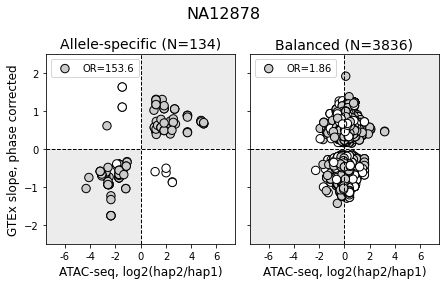

Total: [[19, 10], [7, 33]]
Concordant: [[19, 1], [3, 33]]
Discordant: [[0, 9], [4, 0]]
	CC:52, CD:4
	DC: 0, DD: 13
Odds Ratio (con/disc): inf
Ratio (con/disc): 16.25
Total: [[838, 882], [844, 873]]
Concordant: [[592, 280], [285, 621]]
Discordant: [[246, 602], [559, 252]]
	CC:1213, CD:565
	DC: 498, DD: 1161
Odds Ratio (con/disc): 5.01
Ratio (con/disc): 2.23


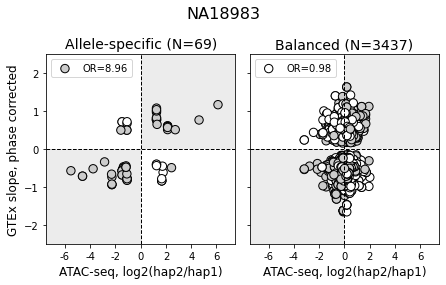

Total: [[39, 0], [0, 34]]
Concordant: [[39, 0], [0, 34]]
Discordant: [[0, 0], [0, 0]]
	CC:73, CD:0
	DC: 0, DD: 0
Odds Ratio (con/disc): nan
Ratio (con/disc): inf
Total: [[816, 795], [839, 1029]]
Concordant: [[601, 281], [297, 682]]
Discordant: [[215, 514], [542, 347]]
	CC:1283, CD:578
	DC: 562, DD: 1056
Odds Ratio (con/disc): 4.17
Ratio (con/disc): 2.05


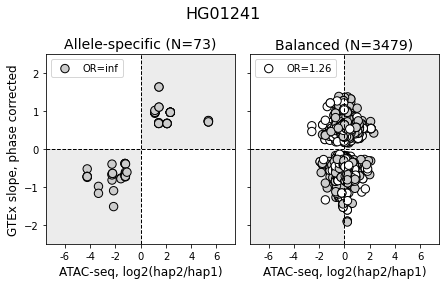

Total: [[27, 0], [4, 29]]
Concordant: [[25, 0], [4, 27]]
Discordant: [[2, 0], [0, 2]]
	CC:52, CD:4
	DC: 4, DD: 0
Odds Ratio (con/disc): 0.0
Ratio (con/disc): 6.5
Total: [[925, 815], [799, 852]]
Concordant: [[587, 283], [283, 630]]
Discordant: [[338, 532], [516, 222]]
	CC:1217, CD:566
	DC: 560, DD: 1048
Odds Ratio (con/disc): 4.02
Ratio (con/disc): 2.01


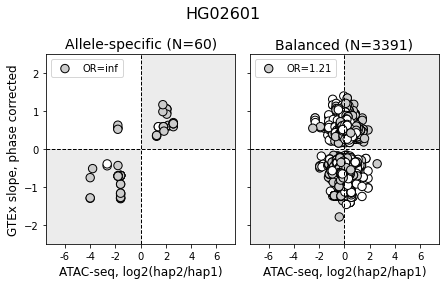

Total: [[151, 2], [18, 15]]
Concordant: [[151, 1], [0, 13]]
Discordant: [[0, 1], [18, 2]]
	CC:164, CD:1
	DC: 2, DD: 19
Odds Ratio (con/disc): 1558.0
Ratio (con/disc): 61.0
Total: [[1064, 1029], [932, 933]]
Concordant: [[744, 474], [397, 643]]
Discordant: [[320, 555], [535, 290]]
	CC:1387, CD:871
	DC: 610, DD: 1090
Odds Ratio (con/disc): 2.85
Ratio (con/disc): 1.67


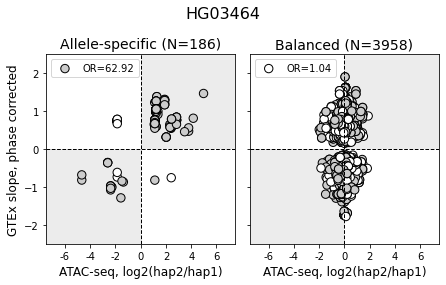

In [30]:
for sample in ['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464']:
    phased_variants = read_variants(sample)
    
    links_allele_specific = pd.read_csv(f'links_{sample}_allele_specific.txt', sep = '\t', header = 0)
    links_balanced = pd.read_csv(f'links_{sample}_balanced.txt', sep = '\t', header = 0)
    
    variants_links_allele_specific = get_variants_for_links(phased_variants, links_allele_specific)
    variants_links_balanced = get_variants_for_links(phased_variants, links_balanced)
    
    variants_links_allele_specific_in_gtex = variants_links_allele_specific.merge(gtex_data, 
                                                                                  left_on = ['chrom_variant', 'start_variant', 'ref_variant', 'alt_variant', 'gene_id'], 
                                                                                  right_on = ['chrom', 'start', 'ref', 'alt', 'gene_id'])
    variants_links_allele_specific_in_gtex['concordant'] = np.sign(variants_links_allele_specific_in_gtex['log2FoldChange_peak']*variants_links_allele_specific_in_gtex['log2FoldChange_gene'])
    
    variants_links_balanced_in_gtex = variants_links_balanced.merge(gtex_data, 
                                                                    left_on = ['chrom_variant', 'start_variant', 'ref_variant', 'alt_variant', 'gene_id'], 
                                                                    right_on = ['chrom', 'start', 'ref', 'alt', 'gene_id'])
    variants_links_balanced_in_gtex['concordant'] = np.sign(variants_links_balanced_in_gtex['log2FoldChange_peak']*variants_links_balanced_in_gtex['log2FoldChange_gene'])

    plt.figure(figsize = (6.3, 4))
    plt.suptitle(sample, fontsize = 16)

    plt.subplot(121)
    plt.title(f'Allele-specific (N={len(variants_links_allele_specific_in_gtex)})', fontsize = 14)
    plt.scatter(variants_links_allele_specific_in_gtex['log2FoldChange_peak'], 
                variants_links_allele_specific_in_gtex['slope']*(variants_links_allele_specific_in_gtex['allele_alt_variant']-variants_links_allele_specific_in_gtex['allele_ref_variant']),
                color = ['#CCCCCC' if x > 0 else 'w' for x in variants_links_allele_specific_in_gtex['concordant'].values], 
                edgecolor = 'k', s = 70, label = f'OR={gtex_slope_odds_ratio(variants_links_allele_specific_in_gtex)}')
    plt.axhline(0, color = 'k', ls = '--', lw = 1)
    plt.axvline(0, color = 'k', ls = '--', lw = 1)
    plt.fill_between([-8, 0], -3, 0, facecolor = 'grey', zorder = 0, alpha = 0.15)
    plt.fill_between([0, 8], 0, 3, facecolor = 'grey', zorder = 0, alpha = 0.15)
    plt.xlabel('ATAC-seq, log2(hap2/hap1)', fontsize = 12)
    plt.ylabel('GTEx slope, phase corrected', fontsize = 12)
    plt.legend(loc = 'upper left')
    plt.xticks([-6, -4, -2, 0, 2, 4, 6], [-6, -4, -2, 0, 2, 4, 6])
    plt.xlim((-7.5, 7.5))
    plt.ylim((-2.5, 2.5))

    plt.subplot(122)
    plt.title(f'Balanced (N={len(variants_links_balanced_in_gtex)})', fontsize = 14)
    plt.scatter(variants_links_balanced_in_gtex['log2FoldChange_peak'], 
                variants_links_balanced_in_gtex['slope']*(variants_links_balanced_in_gtex['allele_alt_variant']-variants_links_balanced_in_gtex['allele_ref_variant']),
                color = ['#CCCCCC' if x > 0 else 'w' for x in variants_links_balanced_in_gtex['concordant'].values], 
                edgecolor = 'k', s = 70, label = f'OR={gtex_slope_odds_ratio(variants_links_balanced_in_gtex)}')
    plt.axhline(0, color = 'k', ls = '--', lw = 1)
    plt.axvline(0, color = 'k', ls = '--', lw = 1)
    plt.fill_between([-8, 0], -3, 0, facecolor = 'grey', zorder = 0, alpha = 0.15)
    plt.fill_between([0, 8], 0, 3, facecolor = 'grey', zorder = 0, alpha = 0.15)
    plt.xlabel('ATAC-seq, log2(hap2/hap1)', fontsize = 12)
    plt.legend(loc = 'upper left')
    plt.xticks([-6, -4, -2, 0, 2, 4, 6], [-6, -4, -2, 0, 2, 4, 6])
    plt.yticks([-2, -1, 0, 1, 2], [])
    plt.xlim((-7.5, 7.5))
    plt.ylim((-2.5, 2.5))

    plt.tight_layout()
    plt.savefig(f'/DATA/users/m.magnitov/hap_phen/figures/links_gtex_slope_{sample}_with_con_disc.pdf', bbox_inches = 'tight')
    plt.show()

In [31]:
sum_for_fisher_as = np.array([[122, 1], [2, 9]]) +\
                    np.array([[52, 4], [0, 13]]) +\
                    np.array([[73, 0], [0, 0]]) +\
                    np.array([[52, 4], [4, 0]]) +\
                    np.array([[164, 1], [2, 19]])
fisher_exact(sum_for_fisher_as)

(237.2875, 3.085904768238818e-43)

In [32]:
sum_for_fisher_bal = np.array([[1545, 508], [668, 1115]]) +\
                    np.array([[1213, 565], [498, 1161]]) +\
                    np.array([[1283, 578], [562, 1056]]) +\
                    np.array([[1217, 566], [560, 1048]]) +\
                    np.array([[1387, 871], [610, 1090]])
fisher_exact(sum_for_fisher_bal)

(4.061688738347333, 0.0)

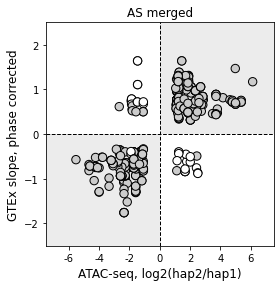

In [33]:
plt.figure(figsize = (4, 4.1))
plt.title('AS merged')

for sample in ['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464'][::-1]:
    phased_variants = read_variants(sample)
    
    links_allele_specific = pd.read_csv(f'links_{sample}_allele_specific.txt', sep = '\t', header = 0)
    
    variants_links_allele_specific = get_variants_for_links(phased_variants, links_allele_specific)
    
    variants_links_allele_specific_in_gtex = variants_links_allele_specific.merge(gtex_data, 
                                                                                  left_on = ['chrom_variant', 'start_variant', 'ref_variant', 'alt_variant', 'gene_id'], 
                                                                                  right_on = ['chrom', 'start', 'ref', 'alt', 'gene_id'])
    variants_links_allele_specific_in_gtex['concordant'] = np.sign(variants_links_allele_specific_in_gtex['log2FoldChange_peak']*variants_links_allele_specific_in_gtex['log2FoldChange_gene'])
    
    plt.scatter(variants_links_allele_specific_in_gtex['log2FoldChange_peak'], 
                variants_links_allele_specific_in_gtex['slope']*(variants_links_allele_specific_in_gtex['allele_alt_variant']-variants_links_allele_specific_in_gtex['allele_ref_variant']),
                color = ['#CCCCCC' if x > 0 else 'w' for x in variants_links_allele_specific_in_gtex['concordant'].values], edgecolor = 'k', s = 70)

plt.axhline(0, color = 'k', ls = '--', lw = 1)
plt.axvline(0, color = 'k', ls = '--', lw = 1)
plt.fill_between([-8, 0], -3, 0, facecolor = 'grey', zorder = 0, alpha = 0.15)
plt.fill_between([0, 8], 0, 3, facecolor = 'grey', zorder = 0, alpha = 0.15)
plt.xlabel('ATAC-seq, log2(hap2/hap1)', fontsize = 12)
plt.ylabel('GTEx slope, phase corrected', fontsize = 12)
plt.xticks([-6, -4, -2, 0, 2, 4, 6], [-6, -4, -2, 0, 2, 4, 6])
plt.xlim((-7.5, 7.5))
plt.ylim((-2.5, 2.5))
plt.tight_layout()
plt.savefig('/DATA/users/m.magnitov/hap_phen/figures/links_gtex_slope_allele_specific_merged_with_cond_disc.pdf', bbox_inches = 'tight')
plt.show()

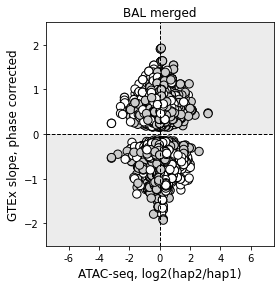

In [34]:
plt.figure(figsize = (4, 4.1))
plt.title('BAL merged')

for sample in ['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464'][::-1]:
    phased_variants = read_variants(sample)
    
    links_balanced = pd.read_csv(f'links_{sample}_balanced.txt', sep = '\t', header = 0)
    
    variants_links_balanced = get_variants_for_links(phased_variants, links_balanced)
    
    variants_links_balanced_in_gtex = variants_links_balanced.merge(gtex_data, 
                                                                    left_on = ['chrom_variant', 'start_variant', 'ref_variant', 'alt_variant', 'gene_id'], 
                                                                    right_on = ['chrom', 'start', 'ref', 'alt', 'gene_id'])
    variants_links_balanced_in_gtex['concordant'] = np.sign(variants_links_balanced_in_gtex['log2FoldChange_peak']*variants_links_balanced_in_gtex['log2FoldChange_gene'])

    plt.scatter(variants_links_balanced_in_gtex['log2FoldChange_peak'], 
                variants_links_balanced_in_gtex['slope']*(variants_links_balanced_in_gtex['allele_alt_variant']-variants_links_balanced_in_gtex['allele_ref_variant']),
                color = ['#CCCCCC' if x > 0 else 'w' for x in variants_links_balanced_in_gtex['concordant'].values], edgecolor = 'k', s = 70)

plt.axhline(0, color = 'k', ls = '--', lw = 1)
plt.axvline(0, color = 'k', ls = '--', lw = 1)
plt.fill_between([-8, 0], -3, 0, facecolor = 'grey', zorder = 0, alpha = 0.15)
plt.fill_between([0, 8], 0, 3, facecolor = 'grey', zorder = 0, alpha = 0.15)
plt.xlabel('ATAC-seq, log2(hap2/hap1)', fontsize = 12)
plt.ylabel('GTEx slope, phase corrected', fontsize = 12)
plt.xticks([-6, -4, -2, 0, 2, 4, 6], [-6, -4, -2, 0, 2, 4, 6])
plt.xlim((-7.5, 7.5))
plt.ylim((-2.5, 2.5))

plt.tight_layout()
plt.savefig('/DATA/users/m.magnitov/hap_phen/figures/links_gtex_slope_balanced_merged_with_conc_disc.pdf', bbox_inches = 'tight')
plt.show()

## Concordance of links with GTEx slopes (all tissues)

In [404]:
def gtex_values_for_odds_ratio_with_conc_disc(variants_gtex):
    if 'concordant' in variants_gtex.columns:
        pp_conc = len(variants_gtex[(variants_gtex['concordant'] > 0) &\
                                    (variants_gtex['log2FoldChange_peak'] > 0) & \
                                    (variants_gtex['slope']*(variants_gtex['allele_alt_variant']-variants_gtex['allele_ref_variant']) > 0)])
        pn_conc = len(variants_gtex[(variants_gtex['concordant'] > 0) &\
                                    (variants_gtex['log2FoldChange_peak'] > 0) & \
                                    (variants_gtex['slope']*(variants_gtex['allele_alt_variant']-variants_gtex['allele_ref_variant']) < 0)])
        np_conc = len(variants_gtex[(variants_gtex['concordant'] > 0) &\
                                    (variants_gtex['log2FoldChange_peak'] < 0) & \
                                    (variants_gtex['slope']*(variants_gtex['allele_alt_variant']-variants_gtex['allele_ref_variant']) > 0)])
        nn_conc = len(variants_gtex[(variants_gtex['concordant'] > 0) &\
                                    (variants_gtex['log2FoldChange_peak'] < 0) & \
                                    (variants_gtex['slope']*(variants_gtex['allele_alt_variant']-variants_gtex['allele_ref_variant']) < 0)])
        
        pp_disc = len(variants_gtex[(variants_gtex['concordant'] < 0) &\
                                    (variants_gtex['log2FoldChange_peak'] > 0) & \
                                    (variants_gtex['slope']*(variants_gtex['allele_alt_variant']-variants_gtex['allele_ref_variant']) > 0)])
        pn_disc = len(variants_gtex[(variants_gtex['concordant'] < 0) &\
                                    (variants_gtex['log2FoldChange_peak'] > 0) & \
                                    (variants_gtex['slope']*(variants_gtex['allele_alt_variant']-variants_gtex['allele_ref_variant']) < 0)])
        np_disc = len(variants_gtex[(variants_gtex['concordant'] < 0) &\
                                    (variants_gtex['log2FoldChange_peak'] < 0) & \
                                    (variants_gtex['slope']*(variants_gtex['allele_alt_variant']-variants_gtex['allele_ref_variant']) > 0)])
        nn_disc = len(variants_gtex[(variants_gtex['concordant'] < 0) &\
                                    (variants_gtex['log2FoldChange_peak'] < 0) & \
                                    (variants_gtex['slope']*(variants_gtex['allele_alt_variant']-variants_gtex['allele_ref_variant']) < 0)])
        
        return(np.array([[pp_conc+nn_conc, pn_conc+np_conc], [pp_disc+nn_disc, pn_disc+np_disc]]))
    else:
        return(np.array([[np.nan, np.nan], [np.nan, np.nan]]))

In [405]:
gtex_tissues = os.listdir('/DATA/users/m.magnitov/hap_phen/links/gtex_data/')
gtex_tissues = sorted([x.split('.')[0] for x in gtex_tissues if 'all_associations' not in x and 'GTEx_Analysis' not in x])
gtex_tissues

['Adipose_Subcutaneous',
 'Adipose_Visceral_Omentum',
 'Adrenal_Gland',
 'Artery_Aorta',
 'Artery_Coronary',
 'Artery_Tibial',
 'Brain_Amygdala',
 'Brain_Anterior_cingulate_cortex_BA24',
 'Brain_Caudate_basal_ganglia',
 'Brain_Cerebellar_Hemisphere',
 'Brain_Cerebellum',
 'Brain_Cortex',
 'Brain_Frontal_Cortex_BA9',
 'Brain_Hippocampus',
 'Brain_Hypothalamus',
 'Brain_Nucleus_accumbens_basal_ganglia',
 'Brain_Putamen_basal_ganglia',
 'Brain_Spinal_cord_cervical_c-1',
 'Brain_Substantia_nigra',
 'Breast_Mammary_Tissue',
 'Cells_Cultured_fibroblasts',
 'Cells_EBV-transformed_lymphocytes',
 'Colon_Sigmoid',
 'Colon_Transverse',
 'Esophagus_Gastroesophageal_Junction',
 'Esophagus_Mucosa',
 'Esophagus_Muscularis',
 'Heart_Atrial_Appendage',
 'Heart_Left_Ventricle',
 'Kidney_Cortex',
 'Liver',
 'Lung',
 'Minor_Salivary_Gland',
 'Muscle_Skeletal',
 'Nerve_Tibial',
 'Ovary',
 'Pancreas',
 'Pituitary',
 'Prostate',
 'Skin_Not_Sun_Exposed_Suprapubic',
 'Skin_Sun_Exposed_Lower_leg',
 'Small_Intes

In [406]:
odd_ratios_as, odd_ratios_bal = [], []

for tissue in gtex_tissues:
    gtex_data = read_significant_gtex_data(tissue)

    sum_for_fisher_as, sum_for_fisher_bal = np.array([[0, 0], [0, 0]]), np.array([[0, 0], [0, 0]])

    for sample in ['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464']:
        phased_variants = read_variants(sample)

        links_allele_specific = pd.read_csv(f'links_{sample}_allele_specific.txt', sep = '\t', header = 0)
        links_balanced = pd.read_csv(f'links_{sample}_balanced.txt', sep = '\t', header = 0)

        variants_links_allele_specific = get_variants_for_links(phased_variants, links_allele_specific)
        variants_links_balanced = get_variants_for_links(phased_variants, links_balanced)

        variants_links_allele_specific_in_gtex = variants_links_allele_specific.merge(gtex_data, 
                                                                                      left_on = ['chrom_variant', 'start_variant', 'ref_variant', 'alt_variant', 'gene_id'], 
                                                                                      right_on = ['chrom', 'start', 'ref', 'alt', 'gene_id'])
        variants_links_allele_specific_in_gtex['concordant'] = np.sign(variants_links_allele_specific_in_gtex['log2FoldChange_peak']*variants_links_allele_specific_in_gtex['log2FoldChange_gene'])

        variants_links_balanced_in_gtex = variants_links_balanced.merge(gtex_data, 
                                                                        left_on = ['chrom_variant', 'start_variant', 'ref_variant', 'alt_variant', 'gene_id'], 
                                                                        right_on = ['chrom', 'start', 'ref', 'alt', 'gene_id'])
        variants_links_balanced_in_gtex['concordant'] = np.sign(variants_links_balanced_in_gtex['log2FoldChange_peak']*variants_links_balanced_in_gtex['log2FoldChange_gene'])

        conf_matrix_as = gtex_values_for_odds_ratio_with_conc_disc(variants_links_allele_specific_in_gtex)
        sum_for_fisher_as = sum_for_fisher_as + conf_matrix_as
        sum_for_fisher_bal += gtex_values_for_odds_ratio_with_conc_disc(variants_links_balanced_in_gtex)

    odd_ratios_as.append(fisher_exact(sum_for_fisher_as)[0])
    odd_ratios_bal.append(fisher_exact(sum_for_fisher_bal)[0])
    
    print(tissue)
    print('\tOR (allele-specific):', fisher_exact(sum_for_fisher_as)[0])
    print('\tOR (balanced):', fisher_exact(sum_for_fisher_bal)[0])
    print()

Adipose_Subcutaneous
	OR (allele-specific): 3.5083840516705997
	OR (balanced): 1.4843654521378493

Adipose_Visceral_Omentum
	OR (allele-specific): 3.200742820907691
	OR (balanced): 1.636339496142796

Adrenal_Gland
	OR (allele-specific): 20.07233273056058
	OR (balanced): 1.673712086368923

Artery_Aorta
	OR (allele-specific): 2.4353568707137416
	OR (balanced): 1.5303568812379034

Artery_Coronary
	OR (allele-specific): 7.4104308390022675
	OR (balanced): 2.0770447197159245

Artery_Tibial
	OR (allele-specific): 3.070891719745223
	OR (balanced): 1.4229406259253927

Brain_Amygdala
	OR (allele-specific): 13.281481481481482
	OR (balanced): 1.553790005570891

Brain_Anterior_cingulate_cortex_BA24
	OR (allele-specific): 14.21875
	OR (balanced): 1.608147049669541

Brain_Caudate_basal_ganglia
	OR (allele-specific): 6.379411764705883
	OR (balanced): 1.400505569561024

Brain_Cerebellar_Hemisphere
	OR (allele-specific): 3.7939882697947214
	OR (balanced): 1.362441192677584

Brain_Cerebellum
	OR (allele-

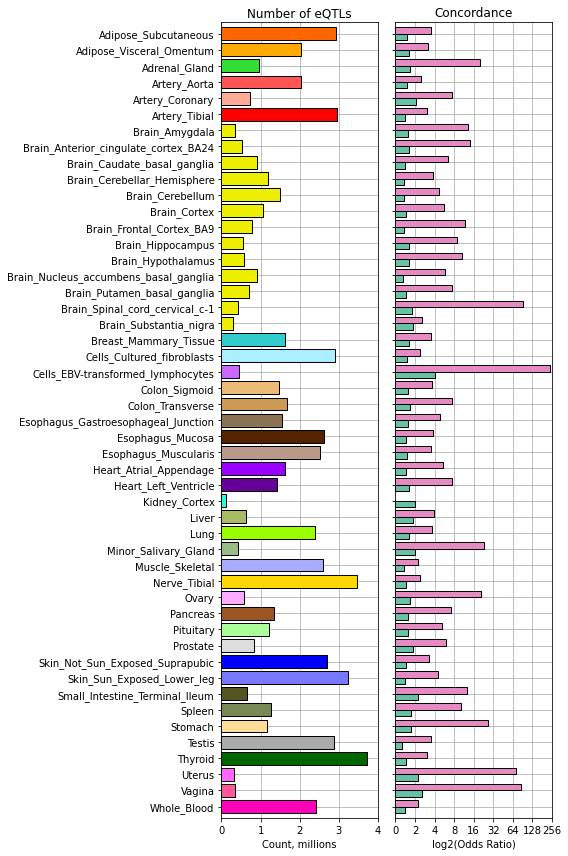

In [427]:
plt.figure(figsize = (8, 12))

plt.subplot(121)
plt.title('Number of eQTLs')
plt.barh(y = np.arange(len(counts_gtex_tissues)), 
            width = counts_gtex_tissues['N_eQTL'][::-1]/1000000, 
            height = 0.8, edgecolor = 'k', color = colors[::-1], lw = 1, label = 'Number of eQTLs', zorder = 4)
plt.ylim((-0.7, len(counts_gtex_tissues)-0.3))
plt.xticks([0, 1, 2, 3, 4])
plt.yticks(np.arange(len(counts_gtex_tissues)), counts_gtex_tissues.index[::-1], rotation = 0)
plt.xlabel('Count, millions')
plt.grid(zorder = 0)

plt.subplot(122)
plt.title('Concordance')
plt.barh(y = np.arange(len(counts_gtex_tissues))+0.2, 
         width = np.log2(odd_ratios_as[::-1]), 
         height = 0.4, edgecolor = 'k', color = '#E68AC3', lw = 1, label = 'Allele-specific', zorder = 4)
plt.barh(y = np.arange(len(counts_gtex_tissues))-0.2,
         width = np.log2(odd_ratios_bal[::-1]), 
         height = 0.4, edgecolor = 'k', color = '#66C2A5', lw = 1, label = 'Balanced', zorder = 4)

plt.xticks(np.arange(9), [0, 2, 4, 8, 16, 32, 64, 128, 256])
plt.xlim((0, 8))
plt.ylim((-0.7, len(counts_gtex_tissues)-0.3))
plt.yticks(np.arange(len(counts_gtex_tissues)), [])
plt.xlabel('log2(Odds Ratio)')
plt.grid(zorder = 0)
    
plt.tight_layout() 
plt.savefig('/DATA/users/m.magnitov/hap_phen/figures/links_concordance_all_tissues.pdf', bbox_inches = 'tight')
plt.show()

## Links in GTEx all tissues (fractions)

In [183]:
colors = ['#FF6600', '#FFAA00', '#33DD33', '#FF5555', '#FFAA99', '#FF0000', '#EEEE00', '#EEEE00', '#EEEE00', '#EEEE00', '#EEEE00',
          '#EEEE00', '#EEEE00', '#EEEE00', '#EEEE00', '#EEEE00', '#EEEE00', '#EEEE00', '#EEEE00', '#33CCCC', '#AAEEFF', '#CC66FF',
          '#EEBB77', '#CC9955', '#8B7355', '#552200', '#BB9988', '#9900FF', '#660099', '#22FFDD', '#AABB66', '#99FF00', '#99BB88',
          '#AAAAFF', '#FFD700', '#FFAAFF', '#995522', '#AAFF99', '#DDDDDD', '#0000FF', '#7777FF', '#555522', '#778855', '#FFDD99',
          '#AAAAAA', '#006600', '#FF66FF', '#FF5599', '#FF00BB']

In [35]:
gtex_tissues = os.listdir('/DATA/users/m.magnitov/hap_phen/links/gtex_data/')
gtex_tissues = sorted([x.split('.')[0] for x in gtex_tissues if 'all_associations' not in x and 'GTEx_Analysis' not in x])
gtex_tissues

['Adipose_Subcutaneous',
 'Adipose_Visceral_Omentum',
 'Adrenal_Gland',
 'Artery_Aorta',
 'Artery_Coronary',
 'Artery_Tibial',
 'Brain_Amygdala',
 'Brain_Anterior_cingulate_cortex_BA24',
 'Brain_Caudate_basal_ganglia',
 'Brain_Cerebellar_Hemisphere',
 'Brain_Cerebellum',
 'Brain_Cortex',
 'Brain_Frontal_Cortex_BA9',
 'Brain_Hippocampus',
 'Brain_Hypothalamus',
 'Brain_Nucleus_accumbens_basal_ganglia',
 'Brain_Putamen_basal_ganglia',
 'Brain_Spinal_cord_cervical_c-1',
 'Brain_Substantia_nigra',
 'Breast_Mammary_Tissue',
 'Cells_Cultured_fibroblasts',
 'Cells_EBV-transformed_lymphocytes',
 'Colon_Sigmoid',
 'Colon_Transverse',
 'Esophagus_Gastroesophageal_Junction',
 'Esophagus_Mucosa',
 'Esophagus_Muscularis',
 'Heart_Atrial_Appendage',
 'Heart_Left_Ventricle',
 'Kidney_Cortex',
 'Liver',
 'Lung',
 'Minor_Salivary_Gland',
 'Muscle_Skeletal',
 'Nerve_Tibial',
 'Ovary',
 'Pancreas',
 'Pituitary',
 'Prostate',
 'Skin_Not_Sun_Exposed_Suprapubic',
 'Skin_Sun_Exposed_Lower_leg',
 'Small_Intes

In [ ]:
counts_gtex_tissues = pd.DataFrame()
for sample in ['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464']:
    phased_variants = read_variants(sample)

    links_allele_specific = pd.read_csv(f'links_{sample}_allele_specific.txt', sep = '\t', header = 0)
    links_balanced = pd.read_csv(f'links_{sample}_balanced.txt', sep = '\t', header = 0)
    
    variants_links_allele_specific = get_variants_for_links(phased_variants, links_allele_specific)
    variants_links_balanced = get_variants_for_links(phased_variants, links_balanced)
    
    counts_gtex_tissues_as, counts_gtex_tissues_balanced = [], []
    for tissue in gtex_tissues:
        gtex_data = read_significant_gtex_data(tissue)
        variants_links_allele_specific_in_gtex = variants_links_allele_specific.merge(gtex_data, 
                                                                                      left_on = ['chrom_variant', 'start_variant', 'ref_variant', 'alt_variant', 'gene_id'], 
                                                                                      right_on = ['chrom', 'start', 'ref', 'alt', 'gene_id'])
        variants_links_balanced_in_gtex = variants_links_balanced.merge(gtex_data, 
                                                                        left_on = ['chrom_variant', 'start_variant', 'ref_variant', 'alt_variant', 'gene_id'], 
                                                                        right_on = ['chrom', 'start', 'ref', 'alt', 'gene_id'])

        counts_gtex_tissues_as.append(len(variants_links_allele_specific_in_gtex)/len(variants_links_allele_specific))
        counts_gtex_tissues_balanced.append(len(variants_links_balanced_in_gtex)/len(variants_links_balanced))
    counts_gtex_tissues[sample + '_as'] = counts_gtex_tissues_as
    counts_gtex_tissues[sample + '_balanced'] = counts_gtex_tissues_balanced
    
counts_gtex_tissues.index = gtex_tissues

eqtls_per_tissue = []
for tissue in gtex_tissues:
    gtex_data = read_significant_gtex_data(tissue)
    eqtls_per_tissue.append(len(gtex_data))
    
counts_gtex_tissues['N_eQTL'] = eqtls_per_tissue

counts_gtex_tissues.to_csv('overlap_links_with_gtex_per_tissue.tsv', sep = '\t', header = 1, index = 1)
counts_gtex_tissues

In [264]:
counts_gtex_tissues = pd.read_csv('overxlap_links_with_gtex_per_tissue.tsv', sep = '\t', header = 0, index_col = 0)
counts_gtex_tissues

,NA12878_as,NA12878_balanced,NA18983_as,NA18983_balanced,HG01241_as,HG01241_balanced,HG02601_as,HG02601_balanced,HG03464_as,HG03464_balanced,N_eQTL
Adipose_Subcutaneous,0.138273,0.032256,0.060634,0.029160,0.043686,0.021758,0.077505,0.031575,0.051139,0.018541,2930370
Adipose_Visceral_Omentum,0.085764,0.023268,0.055504,0.020622,0.040694,0.015565,0.068053,0.022775,0.043882,0.012590,2031091
Adrenal_Gland,0.047841,0.011531,0.024720,0.010956,0.032914,0.008071,0.023945,0.011911,0.032911,0.006501,959376
Artery_Aorta,0.110268,0.023596,0.039179,0.021248,0.038300,0.016050,0.063642,0.022961,0.046076,0.013264,2038599
Artery_Coronary,0.046091,0.008274,0.017257,0.008077,0.026332,0.005609,0.033396,0.008658,0.028186,0.004529,721637
Artery_Tibial,0.122520,0.033754,0.061101,0.030667,0.048474,0.022911,0.059231,0.032473,0.055190,0.018925,2958254
Brain_Amygdala,0.030338,0.003479,0.005131,0.003938,0.016158,0.002528,0.013233,0.003999,0.021097,0.002244,347359
Brain_Anterior_cingulate_cortex_BA24,0.029172,0.005539,0.008396,0.005468,0.023938,0.003806,0.014493,0.005877,0.023460,0.003237,531518
Brain_Caudate_basal_ganglia,0.043757,0.009926,0.019590,0.009649,0.022741,0.006948,0.015123,0.010099,0.031392,0.005667,906716
Brain_Cerebellar_Hemisphere,0.060677,0.012342,0.021922,0.012117,0.014961,0.008480,0.015753,0.013012,0.032574,0.007187,1183391


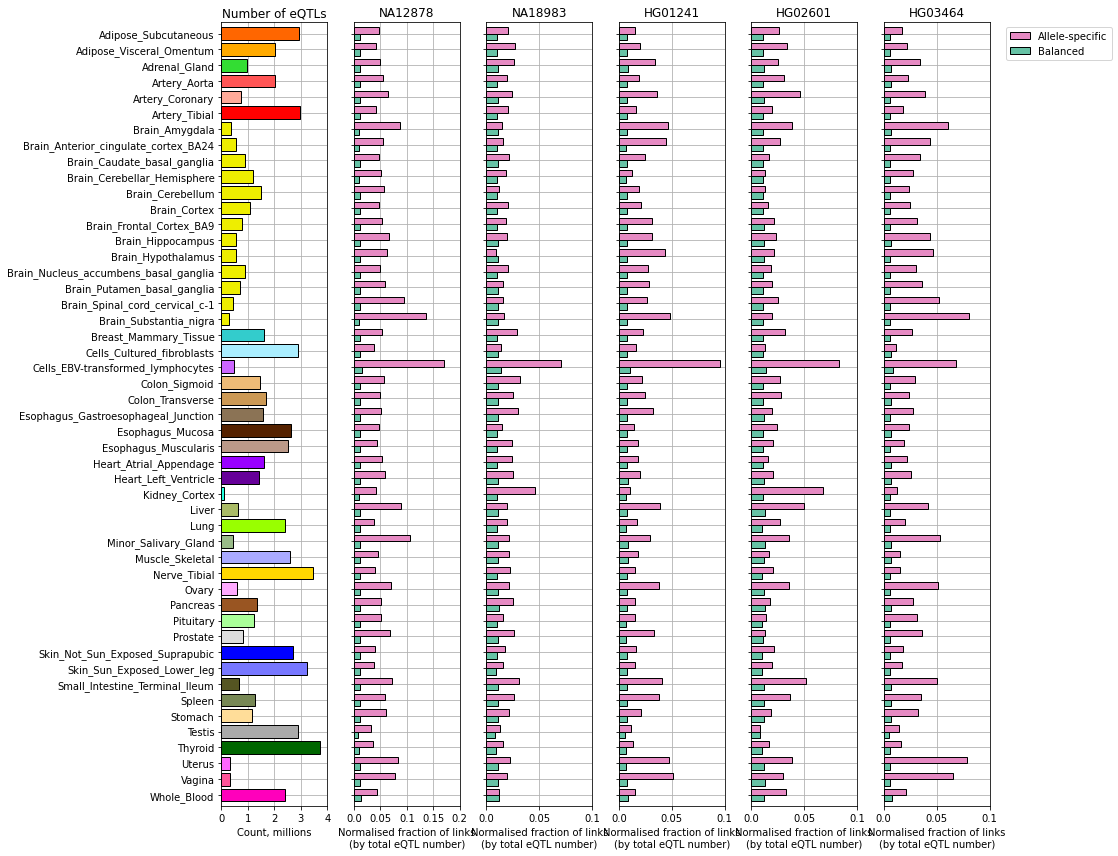

In [88]:
xlims = {'NA12878': 0.2, 'NA18983': 0.1, 'HG01241': 0.1, 'HG02601': 0.1, 'HG03464': 0.1}

plt.figure(figsize = (16, 12))

plt.subplot(1, 6, 1)
plt.title('Number of eQTLs')
plt.barh(y = np.arange(len(counts_gtex_tissues)), 
            width = counts_gtex_tissues['N_eQTL'][::-1]/1000000, 
            height = 0.8, edgecolor = 'k', color = colors[::-1], lw = 1, label = 'Number of eQTLs', zorder = 4)
plt.ylim((-0.7, len(counts_gtex_tissues)-0.3))
plt.xticks([0, 1, 2, 3, 4])
plt.yticks(np.arange(len(counts_gtex_tissues)), counts_gtex_tissues.index[::-1], rotation = 0)
plt.xlabel('Count, millions')
plt.grid(zorder = 0)

for (i, sample) in enumerate(['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464']):
    plt.subplot(1, 6, i+2)
    plt.title(sample)
    plt.barh(y = np.arange(len(counts_gtex_tissues))+0.2, 
            width = (counts_gtex_tissues[sample + '_as']/counts_gtex_tissues['N_eQTL']*1000000)[::-1], 
            height = 0.4, edgecolor = 'k', color = '#E68AC3', lw = 1, label = 'Allele-specific', zorder = 4)
    plt.barh(y = np.arange(len(counts_gtex_tissues))-0.2,
            width = (counts_gtex_tissues[sample + '_balanced']/counts_gtex_tissues['N_eQTL']*1000000)[::-1], 
            height = 0.4, edgecolor = 'k', color = '#66C2A5', lw = 1, label = 'Balanced', zorder = 4)

    
    plt.ylim((-0.7, len(counts_gtex_tissues)-0.3))
    plt.yticks(np.arange(len(counts_gtex_tissues)), [])
    plt.xlabel('Normalised fraction of links\n(by total eQTL number)')
    if i == 4:
        plt.legend(loc = 'upper right', bbox_to_anchor = (2.2, 1))  
    plt.grid(zorder = 0)
    plt.xlim((0, xlims[sample]))
    plt.xticks(np.arange(0, xlims[sample]+0.01, 0.05), [round(x, 2) for x in np.arange(0, xlims[sample]+0.01, 0.05)])
    
plt.tight_layout() 
plt.savefig('/DATA/users/m.magnitov/hap_phen/figures/links_gtex_counts_by_tissue_normalised.pdf', bbox_inches = 'tight')
plt.show()